# Testing the normflows package and augmenting it with Bayesian Methods

In [1]:
import torch
import numpy as np
import normflows as nf
import os

from matplotlib import pyplot as plt

from tqdm import tqdm

from jet_dataset import JetDataset

/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
save_dir = './data/NF_2_jets15/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
###################################
### Define the Normalizing Flow ###
###################################

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

In [6]:
#######################
### Define the data ###
#######################

batch_size = 131072

dataset = JetDataset("./jet_data",'train')
dataset_val = JetDataset("./jet_data",'val')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10)

loaded model from ./data/NF_2_jets15/model_7499.pth


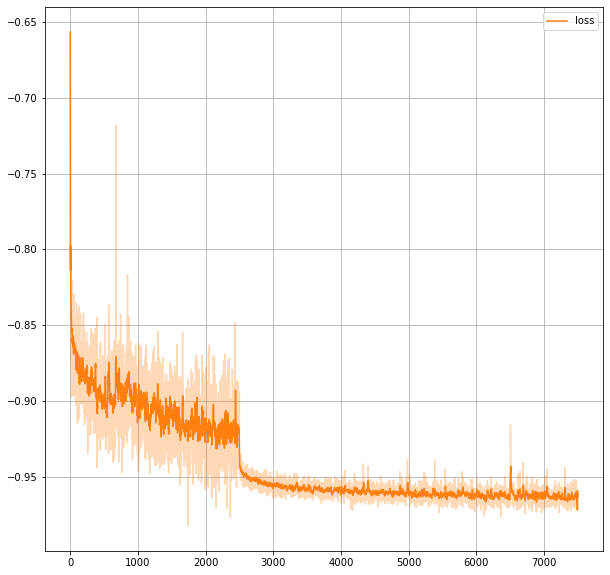

In [7]:
#####################
### Training Loop ###
#####################

train = False
lr = 1e-3
weight_decay = 0 
lr_decay = 1 #0.999

epochs = 7500

if train:
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    loss_hist = np.array([])

    for ep in tqdm(range(epochs)):
        optim.zero_grad()
        
        for x, c in dataloader:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            
            # Compute loss
            loss = model.forward_kld(x, c)
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optim.step()
                scheduler.step()
            
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

        if ep%50 == 0:
            torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")

    model.eval()

    torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
    print('saved model at ' + save_dir + f"model_{ep}.pth")

else:
    ep = epochs-1

    with open(save_dir + f'losses_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)

    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    print('loaded model from ' + save_dir + f"model_{ep}.pth")


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
plt.plot(smooth(loss_hist,11), label='loss', color = 'C1')
plt.grid()
plt.legend()
img_outfile = save_dir + f"image_ep{ep}_loss.png"
plt.savefig(img_outfile)
plt.show()

In [ ]:
print(sum(p.numel() for p in net.parameters()))

100%|██████████| 1000/1000 [00:50<00:00, 20.00it/s]


plotting rocs


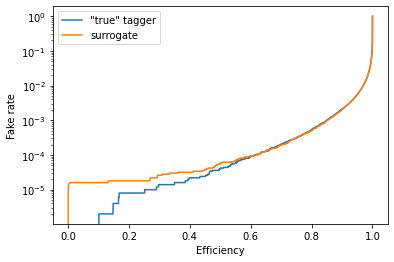

plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen


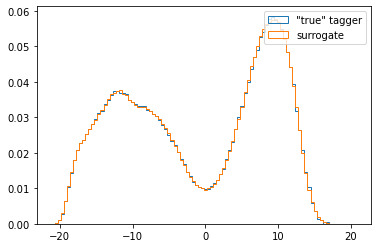

saved images at ./data/NF_2_jets15/


In [8]:
################
### Plotting ###
################

n_stat_alea = 1

from sklearn.metrics import roc_curve

with torch.no_grad():
    # get a batch to compare
    conditions = torch.Tensor(dataset_val.features).to(device)
    
    bs = 1000
    n_bs = len(conditions)//bs+1

    c_new = conditions[:bs]
    x_gen, _ = model.sample(bs*n_stat_alea, context=conditions[:bs].repeat_interleave(n_stat_alea, dim=0))
    for i in tqdm(range(n_bs-1)):
        c_data = conditions[(i+1)*bs:(i+2)*bs]
        c_new = torch.concat((c_new, c_data), 0)
        x_gen_tmp, _ = model.sample(len(c_data)*n_stat_alea, context=c_data.repeat_interleave(n_stat_alea, dim=0))
        x_gen = torch.concat((x_gen, x_gen_tmp), 0)

    conditions = c_new
    x_gen = x_gen.reshape(len(conditions), n_stat_alea, -1)
    #x_gen_unc_alea = x_gen.std(1)*20. #THIS DOES NOT MAKE SENSE FOR PLOTTING AS THE FULL DIST IS THE SUM OVER ALL DISTS AND NOT THEIR MEANS
    #x_gen = x_gen.mean(1)*20. #back to full scale
    x_gen = x_gen.reshape(-1,1)*20.
    x_gen_raw = x_gen 
    x_gen = torch.sigmoid(x_gen)
    print("plotting rocs")
    fpr,tpr,_ = roc_curve(dataset_val.truth, dataset_val.raw_target)
    gfpr,gtpr,_ = roc_curve(dataset_val.truth, x_gen.cpu())
    plt.plot(tpr, fpr, label='"true" tagger')
    plt.plot(gtpr, gfpr, label='surrogate')
    plt.xlabel("Efficiency")
    plt.ylabel("Fake rate")
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}.png"
    plt.savefig(img_outfile)

    plt.yscale('log')
    img_outfile = save_dir + f"image_ep{ep}_log.png"
    plt.savefig(img_outfile)
    plt.show()

    print("plotting raw", dataset_val.target.shape, x_gen_raw.shape)
    _,b,_ = plt.hist(dataset_val.target[:,0]*20.,bins=100, label='"true" tagger', histtype='step', density=True)
    print("plotting raw gen")
    plt.hist(x_gen_raw.cpu().numpy()[:,0],bins=b, label='surrogate', histtype='step', density=True)
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}_raw.png"
    plt.savefig(img_outfile)
    plt.show()
    print('saved images at ' + save_dir)

(array([6.000e+00, 1.000e+00, 1.800e+01, 2.620e+02, 2.810e+02, 2.660e+02,
        2.260e+03, 4.301e+03, 2.252e+03, 3.530e+02]),
 array([-0.1856713,  1.4257804,  3.0372322,  4.648684 ,  6.2601357,
         7.8715878,  9.483039 , 11.094491 , 12.705943 , 14.317394 ,
        15.928846 ], dtype=float32),
 <BarContainer object of 10 artists>)

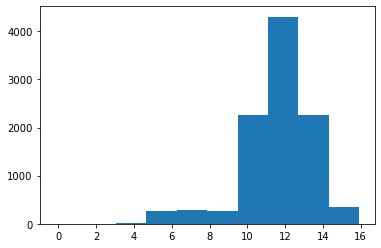

In [9]:
i = 900013

conditions = torch.Tensor(dataset_val.features).to(device)
n_stat_alea = 10000
x_gen, _ = model.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))

x_gen *= 20

plt.hist(x_gen.detach().cpu().numpy())


In [10]:
import hamiltorch_flows.hamiltorch as hamiltorch
from copy import deepcopy as dc

In [11]:
train = False

step_size = 0.00001
num_samples = 1000
L = 30
burn = -1
store_on_GPU = True
debug = False
mass = 500.0

bs_max = 100000

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

tau = 1.0 # Prior Precision
r = 0 # Random seed

tau_list = []
for w in model.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(model).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass

if train:
    print(params_init.shape)
    integrator = hamiltorch.Integrator.EXPLICIT
    sampler = hamiltorch.Sampler.HMC

    hamiltorch.set_random_seed(r)
    params_hmc_f = hamiltorch.sample_model(model, 
                                           x = torch.Tensor(dataset.target[:bs_max]).to(device), 
                                           cond= torch.Tensor(dataset.features[:bs_max]).to(device),
                                           params_init=params_init,
                                           num_samples=num_samples,
                                           burn = burn, 
                                           inv_mass=inv_mass.to(device),
                                           step_size=step_size,
                                           num_steps_per_sample=L,
                                           #tau_out=tau_out, 
                                           tau_list=tau_list,
                                           debug=debug, 
                                           store_on_GPU=store_on_GPU,
                                           sampler = sampler)

    torch.save(params_hmc_f, save_dir + f"hmc_models.pth")

In [12]:
params_hmc_f = torch.load(save_dir + f"hmc_models.pth")

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]


In [13]:
pred_list_val, log_probs_f_val, ll_full = hamiltorch.predict_model(model, 
                                                  x = torch.Tensor(dataset.target[:bs_max]).to(device), 
                                                  cond=torch.Tensor(dataset.features[:bs_max]).to(device), 
                                                  samples=params_hmc_gpu,
                                                  #tau_out=tau_out,
                                                  tau_list=tau_list)

 17%|█▋        | 174/1000 [00:56<04:50,  2.84it/s]100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


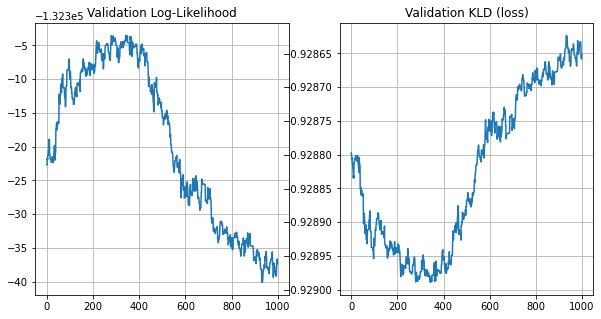

In [14]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.set_title('Validation Log-Likelihood')
ax1.plot(torch.Tensor(log_probs_f_val).detach().cpu().numpy())
ax1.grid()

ax2.set_title('Validation KLD (loss)')
ax2.plot(torch.Tensor(ll_full).detach().cpu().numpy())
ax2.grid()

/home/bierings/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/bierings/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


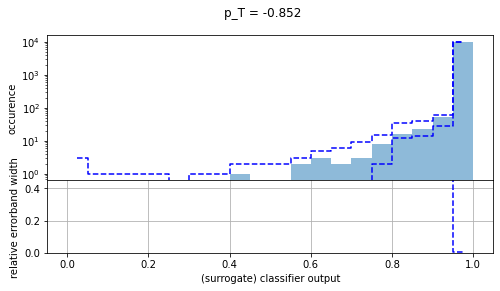

/home/bierings/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


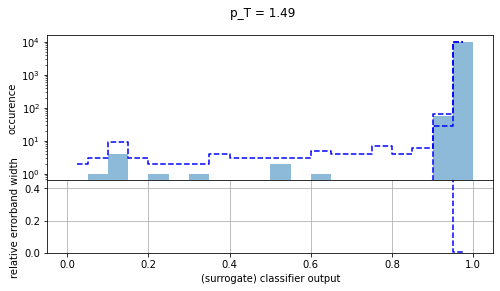

/home/bierings/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


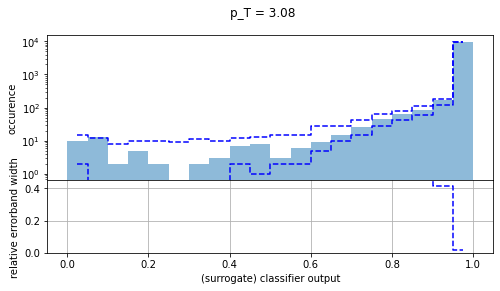

In [15]:
sort = np.argsort(dataset_val.features[:,1])
bins = np.linspace(0,1,21)

for k in [200003, -100005, -10000]:
    fig,ax = plt.subplots(2,1, figsize = (8,4), sharex = True, gridspec_kw={'height_ratios': [2,1], 'hspace': 0.})
    i = sort[k]
    conditions = torch.Tensor(dataset_val.features).to(device)
    c = conditions[i:i+1]

    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    n_stat_alea = 10000
    x_gen, _ = model.sample(1*n_stat_alea, context=c.repeat_interleave(n_stat_alea, dim=0))

    x_gen = torch.sigmoid(x_gen*20)
    hist_orig,b,_ = ax[0].hist(x_gen.detach().cpu().numpy(),  bins = bins, alpha=0.5)

    hists = []
    for j,param in enumerate(params_hmc_gpu[::10]):
        print(j, end='\r')
        torch.nn.utils.vector_to_parameters(param, model.parameters())
        n_stat_alea = 10000
        x_gen, _ = model.sample(1*n_stat_alea, context=c.repeat_interleave(n_stat_alea, dim=0))
        
        x_gen = torch.sigmoid(x_gen*20)
        hist, b = np.histogram(x_gen.detach().cpu().numpy(), bins = b)
        hists.append(hist)
    
    hists = np.array(hists)
    hist_max = hists.max(0)
    hist_min = hists.min(0)

    bincentres = [(b[i]+b[i+1])/2. for i in range(len(b)-1)]
    ax[0].step(bincentres, hist_max, where='mid',color='b',linestyle='--')
    ax[0].step(bincentres, hist_min, where='mid',color='b',linestyle='--')
    ax[0].set_ylabel('occurence')
    ax[0].set_yscale('log')
    
    ax[1].step(bincentres, (hist_max-hist_min)/hist_orig, where='mid',color='b',linestyle='--')
    ax[1].set_ylabel('relative errorband width')
    ax[1].set_ylim(0,0.45)
    ax[1].set_xlabel('(surrogate) classifier output')
    ax[1].grid()
    
    fig.suptitle(f'p_T = {dataset_val.features[i,1]:.3}')
    plt.savefig(f'./out_{i}_hmc.pdf')
    plt.show()

In [16]:
### plot the relative error of the full validation set in selected bin ###

eval = False

if eval:
    top_data_val = dataset_val.features[dataset_val.features[:,0]==1.]
    ntop_data_val = dataset_val.features[dataset_val.features[:,0]==-1.]

    sort = np.argsort(dataset_val.features[:,1])
    bins = np.linspace(0,1,21)

    batchsize = 200

    for data_id,d in enumerate([top_data_val]):#, ntop_data_val]):
        x = np.zeros(len(d))
        ys = np.zeros((len(d),len(bins)-1))
        for k in tqdm(range(len(d)//batchsize)):
            
            n_stat_alea = 1000

            c = torch.Tensor(dataset_val.features[k*batchsize:(k+1)*batchsize]).to(device)
            c = c.repeat_interleave(n_stat_alea, dim=0)

            hists = np.zeros((batchsize, len(params_hmc_gpu[::100]), len(bins)-1))
            for j,param in enumerate(params_hmc_gpu[::100]):
                torch.nn.utils.vector_to_parameters(param, model.parameters())
                x_gen, _ = model.sample(batchsize*n_stat_alea, context=c)
                
                x_gen = torch.sigmoid(x_gen*20)
                for batch in range(batchsize):
                    hist, _ = np.histogram(x_gen[batch*n_stat_alea:(batch+1)*n_stat_alea].detach().cpu().numpy(), bins = bins)
                    hists[batch, j] = hist
            
            hist_max = hists.max(1)
            hist_min = hists.min(1)

            x[k*batchsize:(k+1)*batchsize] = top_data_val[k*batchsize:(k+1)*batchsize,1]
            ys[k*batchsize:(k+1)*batchsize] = hist_max - hist_min

        if data_id==0:
            with open('./top_hist_errors_hmc.npy', 'wb') as f:
                np.save(f, ys)
            with open('./top_hist_pT_hmc.npy', 'wb') as f:
                np.save(f, x)

        if data_id==1:
            with open('./ntop_hist_errors_hmc.npy', 'wb') as f:
                np.save(f, ys)
            with open('./ntop_hist_pT_hmc.npy', 'wb') as f:
                np.save(f, x)

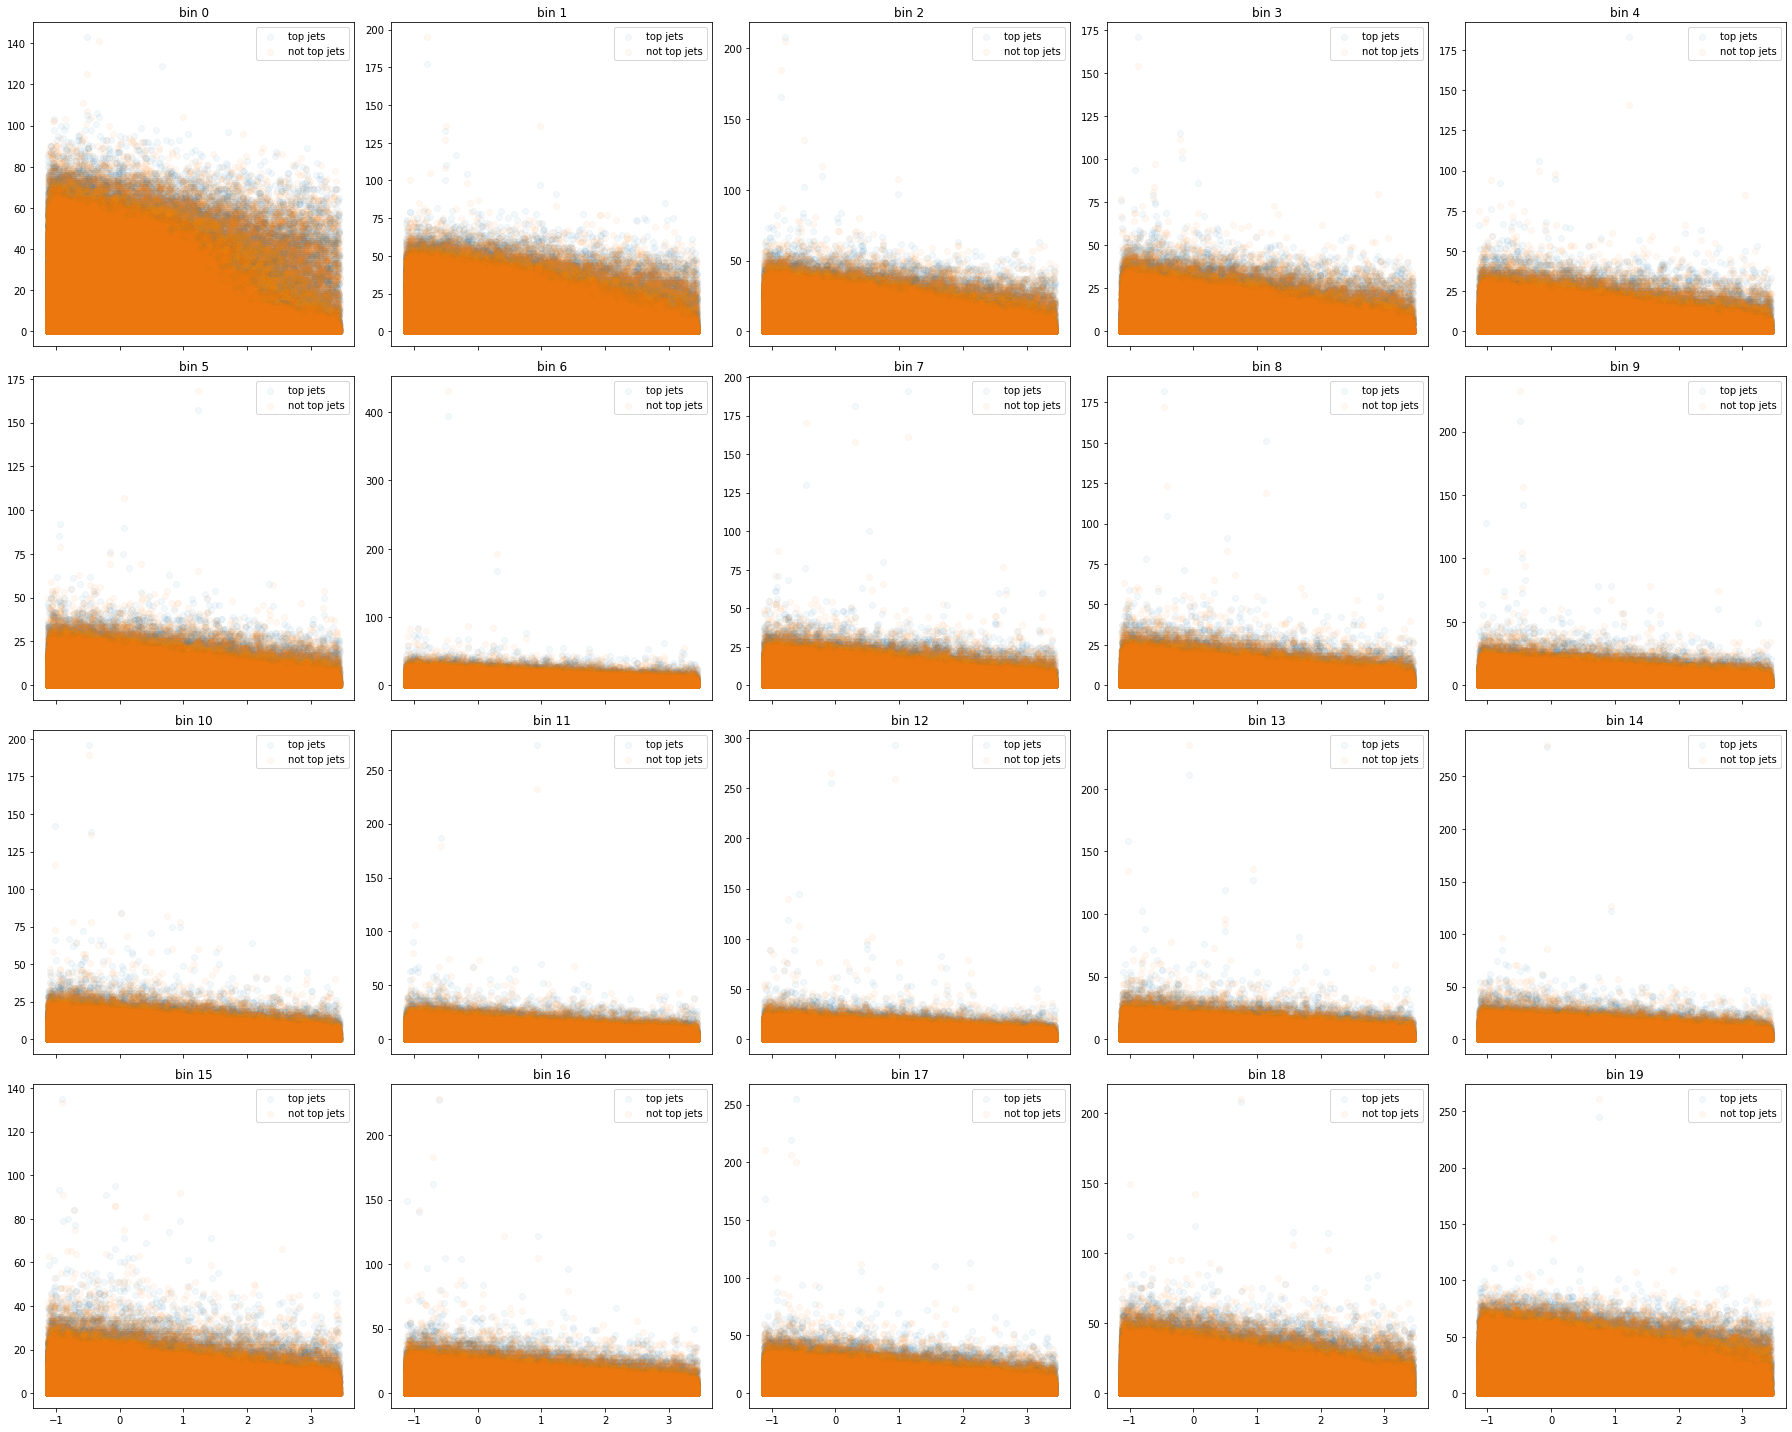

In [23]:
fig, ax = plt.subplots(4,5, figsize = (25,20), sharex = True, )
ax = ax.flatten()

for jet_class in ['top jets', 'not top jets']:
    if jet_class=='top jets':
        with open('./top_hist_errors_hmc.npy', 'rb') as f:
            ys = np.load(f)
        with open('./top_hist_pT_hmc.npy', 'rb') as f:
            x = np.load(f)

    if jet_class=='not top jets':
        with open('./ntop_hist_errors_hmc.npy', 'rb') as f:
            ys = np.load(f)
        with open('./ntop_hist_pT_hmc.npy', 'rb') as f:
            x = np.load(f)

    for n_bin in range(ys.shape[1]):
        ax[n_bin].scatter(x, ys[:,n_bin], label = jet_class, alpha = .05)
        ax[n_bin].legend(loc='upper right')
        ax[n_bin].grid()
        ax[n_bin].set_title(f'bin {n_bin}')
    
fig.tight_layout()
